# Load the dataset


In [1]:
import os
import cv2
from torch.utils.data import Dataset

class BlinkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

        self.images=[]
        self.labels=[]

        open_dir = os.path.join(root_dir, 'open')
        for img_name in os.listdir(open_dir):
            if img_name.endswith('.png'):
                self.images.append(os.path.join(open_dir, img_name))
                self.labels.append(0)

        closed_dir = os.path.join(root_dir, 'closed')
        for img_name in os.listdir(closed_dir):
            if img_name.endswith('.png'):
                self.images.append(os.path.join(closed_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Visualize data samples

11545


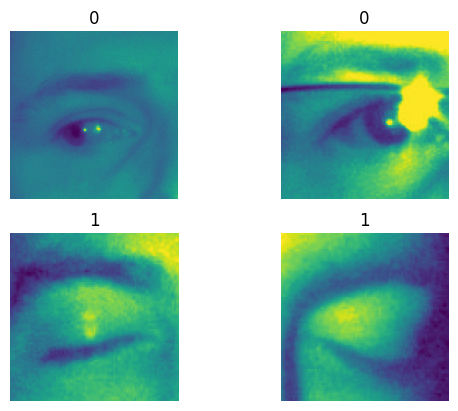

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data = BlinkDataset(os.curdir + '/data')
print(data.__len__())

for i in range(4):
    idx = i + 7715
    image, label = data.__getitem__(idx)
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

# Get shape and see what the image data looks like

In [3]:
image, label = data.__getitem__(100)
print(image.shape)

print(image)

(142, 142)
[[105 104 105 ... 140 141 139]
 [106 105 106 ... 137 143 140]
 [106 106 107 ... 135 145 141]
 ...
 [128 127 125 ... 110 110 108]
 [124 123 121 ... 110 111 109]
 [124 124 122 ... 111 113 111]]


# Generate mean and standard deviation for normalization

## Loading all of the data

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

data = BlinkDataset(os.curdir + '/data', transform=transform)

full_loader = DataLoader(
    data
)


## Calculating mean and std

In [5]:
from tqdm.notebook import tqdm

mean = torch.zeros(1)
std = torch.zeros(1)

for images, labels in tqdm(full_loader):
        mean += images.float().mean() 
        std += images.float().std() 

print(mean.div_(len(data)))
print(std.div_(len(data)))

  0%|          | 0/11545 [00:00<?, ?it/s]

tensor([0.4111])
tensor([0.1058])


# Now using a feature extractor to map images into proper shape for pretrained model

## Redefining BlinkDataset to incorporate feature extractor

In [7]:
from PIL import Image

class BlinkDataset(Dataset):
    def __init__(self, root_dir, feature_extractor=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.images = os.listdir(root_dir)

        self.images=[]
        self.labels=[]

        open_dir = os.path.join(root_dir, 'open')
        for img_name in os.listdir(open_dir):
            if img_name.endswith('.png'):
                self.images.append(os.path.join(open_dir, img_name))
                self.labels.append(0)

        closed_dir = os.path.join(root_dir, 'closed')
        for img_name in os.listdir(closed_dir):
            if img_name.endswith('.png'):
                self.images.append(os.path.join(closed_dir, img_name))
                self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        label = self.labels[idx]

        features = []
        if self.feature_extractor:
            features = self.feature_extractor(images=image, return_tensors="pt")
            features = {k: v.squeeze(0) for k, v in features.items()}

        if self.transform:
            features["pixel_values"] = self.transform(features["pixel_values"])
        
        return features, label

In [8]:
from torchvision import transforms
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

transform = transforms.Compose([
    transforms.Normalize(mean=0.4111, std=0.1085),
])

data = BlinkDataset(os.curdir + '/data', feature_extractor=feature_extractor, transform=transform)

train_size = int(0.8*len(data))
test_size = len(data) - train_size

train_data, test_data = torch.utils.data.random_split(
    data, [train_size, test_size]
)

train_loader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    train_data,
    batch_size=128,
    shuffle=True
)

/home/blaine/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Evaluation

Here we're creating an average attention map across the data to see what the pretrained transformer is looking at.

In [9]:
from transformers import ViTModel
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

average_attention=torch.zeros(size=(14, 14))

outputs = []
for batch in tqdm(train_loader):
    inputs = batch[0]["pixel_values"].to(device)
    with torch.no_grad():
        outputs = model(inputs, output_hidden_states=True, output_attentions=True)
        hidden_states = outputs.hidden_states
        attention_weights = outputs.attentions[-1]

        for idx in range(inputs.size(0)): 
            attention_head = attention_weights[idx][0, 0, 1:]
            num_patches = attention_head.size(0)
            attention_map = attention_head.detach().cpu().numpy()

            attention_map = attention_map.reshape(14, 14)

            average_attention += attention_map



  0%|          | 0/73 [00:00<?, ?it/s]

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
/tmp/ipykernel_81880/4006857490.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  average_attention += attention_map


In [ ]:
# Calculate average
average_attention /= len(train_data)

In [1]:
# Display the attention map for the current image
plt.imshow(average_attention, cmap='hot')
plt.colorbar()
plt.title(f'Average Attention Map')
plt.show()

NameError: name 'plt' is not defined

# Now we make a new model from the pretrained, and hyper-tune

You will need to reset your kernel here, otherwise you won't have enough GPU space.

In [14]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Normalize(mean=0.4111, std=0.1085),
])

model_name = "google/vit-base-patch16-224-in21k"
model = AutoModelForImageClassification.from_pretrained(model_name)
extractor = AutoFeatureExtractor.from_pretrained(model_name)

finetuneData = BlinkDataset(os.curdir + '/data', feature_extractor=extractor, transform=transform)

train_size = int(0.8 * len(finetuneData))
test_size = len(finetuneData) - train_size

train_data_finetune, test_data_finetune = torch.utils.data.random_split(
    finetuneData, [train_size, test_size]
)

train_loader_finetune = DataLoader(
    train_data_finetune,
    batch_size=64,
    shuffle=True
)

test_loader_finetune = DataLoader(
    test_data_finetune,
    batch_size=64,
    shuffle=True
)

model.classifier = torch.nn.Linear(model.config.hidden_size, 2)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

model.train()
model.to(device)
for epoch in range(1):
    for images, labels in tqdm(train_loader_finetune):
        input = images["pixel_values"]
        input = input.to(device)
        labels = labels.to(device)
        outputs = model(input)
        loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/blaine/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


  0%|          | 0/145 [00:00<?, ?it/s]

In [17]:
torch.save(model.state_dict(), './model.pth')

In [19]:
model.eval()

correct = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader_finetune):
        input = images["pixel_values"]
        input = input.to(device)
        labels = labels.to(device)
        outputs = model(input)

        predicted_class_idx = torch.argmax(outputs.logits, dim=-1)

        correct += (predicted_class_idx == labels).sum().item()

  0%|          | 0/37 [00:00<?, ?it/s]

TypeError: object of type 'int' has no len()

In [20]:

print(f"Acc: {correct / test_size}")

Acc: 0.8306626245127761


  0%|          | 0/145 [00:00<?, ?it/s]

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


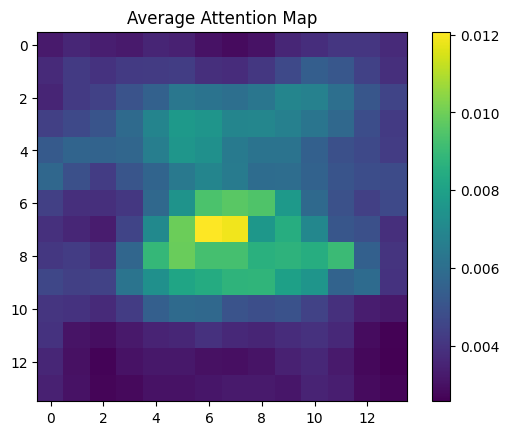

In [21]:
average_attention = torch.zeros(size=(14, 14))

for batch in tqdm(train_loader_finetune):
    inputs = batch[0]["pixel_values"].to(device)
    
    # Perform the forward pass
    with torch.no_grad():
        outputs = model(inputs, output_hidden_states=True, output_attentions=True)
        
        attention_weights = outputs.attentions[-1] 

        for idx in range(inputs.size(0)):
            attention_head = attention_weights[idx][0, 0, 1:] 
            attention_map = attention_head.detach().cpu().numpy()

            attention_map = attention_map.reshape(14, 14)

            average_attention += torch.tensor(attention_map)

average_attention /= len(train_loader_finetune.dataset)

import matplotlib.pyplot as plt

plt.imshow(average_attention.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Average Attention Map")
plt.show()